In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.dataset import EmotionDataset
from scripts.cnnnet import CNNNetwork
from scripts.data_loader import create_data_loader

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
RECORDING_DF_PATH = os.path.join('data', 'recording_paths.csv')
RECORDING_TRAIN_PATH = os.path.join('data', 'recording_paths_train.csv')
RECORDING_TEST_PATH = os.path.join('data', 'recording_paths_test.csv')

FINAL_SR = 16000
NUM_SAMPLES_LIMIT = 60000
BATCH_SIZE = 128

In [5]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=FINAL_SR,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

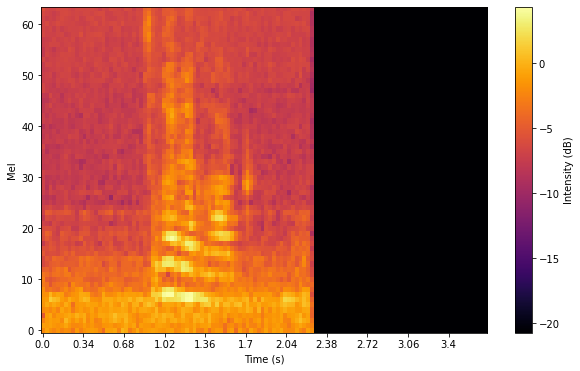

In [6]:
emd_train = EmotionDataset(RECORDING_TRAIN_PATH, FINAL_SR, NUM_SAMPLES_LIMIT, mel_spectrogram, device)
emd_test = EmotionDataset(RECORDING_TEST_PATH, FINAL_SR, NUM_SAMPLES_LIMIT, mel_spectrogram, device)

emd_train.plot_spectrogram(200, log=True)

In [41]:
train_dataloader = create_data_loader(emd_train, BATCH_SIZE)
valid_dataloader = create_data_loader(emd_test, BATCH_SIZE)
loss_fn = nn.CrossEntropyLoss()

cnn = CNNNetwork(num_layers=7,
                learning_rate=0.0005,
                loss_fn = loss_fn,
                device=device,
                train_data_loader = train_dataloader,
                validate_data_loader = valid_dataloader
                ).to(device)

print(summary(cnn, (1, 64, 118)))
print()

cnn.train(num_epochs=36)

torch.save(cnn.state_dict(), "models/cnn.pth")
print("Trained cnn saved at models/cnn.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 120]             160
              ReLU-2          [-1, 16, 66, 120]               0
         MaxPool2d-3           [-1, 16, 33, 60]               0
         Dropout2d-4           [-1, 16, 33, 60]               0
            Conv2d-5           [-1, 32, 35, 62]           4,640
              ReLU-6           [-1, 32, 35, 62]               0
         MaxPool2d-7           [-1, 32, 17, 31]               0
         Dropout2d-8           [-1, 32, 17, 31]               0
            Conv2d-9           [-1, 64, 19, 33]          18,496
             ReLU-10           [-1, 64, 19, 33]               0
        MaxPool2d-11            [-1, 64, 9, 16]               0
        Dropout2d-12            [-1, 64, 9, 16]               0
           Conv2d-13          [-1, 128, 11, 18]          73,856
             ReLU-14          [-1, 128,

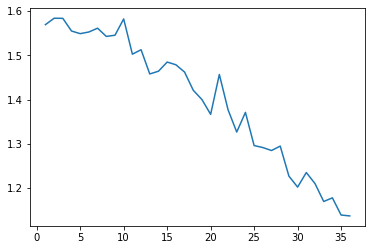

In [42]:
epoch_losses = cnn.get_train_epoch_losses()
plt.plot(list(range(1, len(epoch_losses) + 1)), epoch_losses)

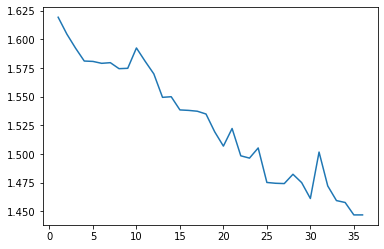

In [43]:
valid_losses = cnn.get_valid_epoch_losses()
plt.plot(list(range(1, len(valid_losses) + 1)), valid_losses)

In [44]:
class_mapping = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

# state_dict = torch.load("models/cnn.pth")
# cnn.load_state_dict(state_dict)

idx = 1

inp, target = emd_train[idx][0], emd_train[idx][1]
inp.unsqueeze_(0)

predicted, expected = cnn.predict(inp, target, class_mapping)
print(f"Predicted: '{predicted}', expected: '{expected}'")

Predicted: 'SAD', expected: 'SAD'


In [45]:
train_df = pd.read_csv('data/recording_paths_train.csv')
expected = train_df.category

predictions = []
for i in range(len(emd_train)):
    inp, target = emd_train[i][0], emd_train[i][1]
    inp.unsqueeze_(0)
    predictions.append(cnn.predict(inp, target, class_mapping)[0])
    
    if i % 1000 == 0:
        print(f'{i} / {len(emd_train)} Done')

0 / 5953 Done
1000 / 5953 Done
2000 / 5953 Done
3000 / 5953 Done
4000 / 5953 Done
5000 / 5953 Done


In [46]:
confusion_matrix(expected, np.array(predictions))

array([[892,  49,  13,  36,  25,   2],
       [ 89, 651,  38,  69,  60, 110],
       [ 52,  54, 498, 153,  81, 179],
       [ 65,  45,  40, 777,  65,  24],
       [  2,  33,   4,  19, 774,  37],
       [  8,  73,  46,  24,  89, 777]])

In [47]:
from sklearn.metrics import classification_report

print(classification_report(expected, np.array(predictions)))

              precision    recall  f1-score   support

         ANG       0.81      0.88      0.84      1017
         DIS       0.72      0.64      0.68      1017
         FEA       0.78      0.49      0.60      1017
         HAP       0.72      0.76      0.74      1016
         NEU       0.71      0.89      0.79       869
         SAD       0.69      0.76      0.72      1017

    accuracy                           0.73      5953
   macro avg       0.74      0.74      0.73      5953
weighted avg       0.74      0.73      0.73      5953



In [48]:
test_df = pd.read_csv('data/recording_paths_test.csv')
expected = test_df.category

predictions = []
for i in range(len(emd_test)):
    inp, target = emd_test[i][0], emd_test[i][1]
    inp.unsqueeze_(0)
    predictions.append(cnn.predict(inp, target, class_mapping)[0])
    
    if i % 100 == 0:
        print(f'{i} / {len(emd_test)} Done')

0 / 1489 Done
100 / 1489 Done
200 / 1489 Done
300 / 1489 Done
400 / 1489 Done
500 / 1489 Done
600 / 1489 Done
700 / 1489 Done
800 / 1489 Done
900 / 1489 Done
1000 / 1489 Done
1100 / 1489 Done
1200 / 1489 Done
1300 / 1489 Done
1400 / 1489 Done


In [49]:
confusion_matrix(expected, np.array(predictions))

array([[186,  19,   2,  36,   9,   2],
       [ 29, 133,   5,  23,  27,  37],
       [ 14,  16,  91,  66,  14,  53],
       [ 36,  12,  24, 152,  29,   2],
       [  3,  13,   6,  17, 164,  15],
       [  2,  24,  21,   7,  36, 164]])

In [50]:
print(classification_report(expected, np.array(predictions)))

              precision    recall  f1-score   support

         ANG       0.69      0.73      0.71       254
         DIS       0.61      0.52      0.56       254
         FEA       0.61      0.36      0.45       254
         HAP       0.50      0.60      0.55       255
         NEU       0.59      0.75      0.66       218
         SAD       0.60      0.65      0.62       254

    accuracy                           0.60      1489
   macro avg       0.60      0.60      0.59      1489
weighted avg       0.60      0.60      0.59      1489



In [ ]:
class_mapping = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']